We need a light level of 9. The probability of a crop growing upon recieving a random tick is $\frac{1}{\lfloor 25/points \rfloor + 1}$ where points is the following.

- The farmland block the crop is planted on gives 2 points if dry or 4 if hydrated.
- For each of the 8 blocks around the block on which the crop is planted, dry farmland gives 0.25 points, and hydrated farmland gives 0.75.
- If any plants of the same type are growing in the eight surrounding blocks, the point total is cut in half (except in some cases. See https://minecraft.fandom.com/wiki/Tutorials/Crop_farming#Growth_rate)

We will assume that all farmland is hydrated.

In [56]:
from sympy import *

# we calculate points for blocks that are surrounded by farmland (and crops on that farmland)
middle_points = (4 + Rational("0.75") * 8)/2

middle_probability = 1 / (floor(25/middle_points) + 1)
middle_probability

1/6

In [57]:
# we calculate points for blocks that are on the side
#   O X O
#   O O O
side_points = (4 + Rational("0.75") * 5)/2

side_probability = 1 / (floor(25/side_points) + 1)
side_probability

1/7

In [58]:
# we calculate points for blocks that are in the corner
#   X O
#   O O
corner_points = (4 + Rational("0.75") * 3)/2

corner_probability = 1 / (floor(25/corner_points) + 1)
corner_probability

1/9

In [59]:
# For now we ignore that there's water in the middle
width = 18
depth = 9

corner_blocks = 4
side_blocks = (width-2)*2 + (depth-2)*2
middle_blocks = (width-2) * (depth-2)
total_blocks = width*depth
assert(corner_blocks + side_blocks + middle_blocks == total_blocks)

Every game tick, each 16x16x16 subchunk receives a number of attempts at random ticks (by default $3$, given by the randomTickSpeed game rule). For now we'll just consider a single random tick. In a subchunk there are $4096$ blocks, so a $\frac{1}{4096}$ chance of a block being chosen for a random tick.

In [60]:
block_chance = Rational("1/4096")
chance_of_not_growing = 1-block_chance*middle_probability

# We assume we only have middle_blocks, and we want to know how many ticks it takes to have 50% of the crops be grown.
wanted_growth = Rational("0.5")
ticks_needed = ln(1-wanted_growth) / ln(chance_of_not_growing)
display(ticks_needed.n())
minutes_needed = (ticks_needed/20)/60
minutes_needed.n()

17034.4385335005

14.1953654445838

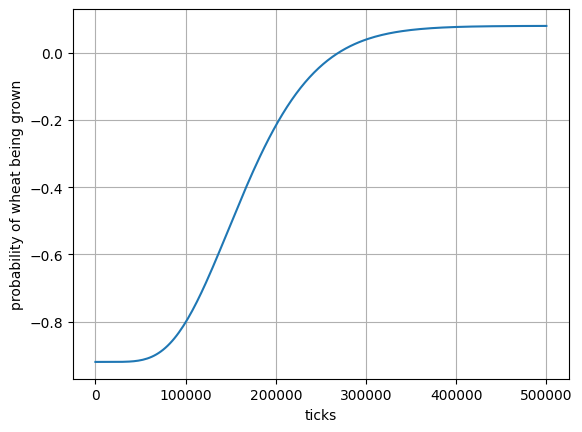

269511.1405853521
In order to have roughly 0.92 of the farm be done, we need to wait 3.7432102859076677 hours
wheat per hour: 39.81609063244499


In [93]:
import scipy
from scipy.optimize import fsolve
import numpy as np
import math
import matplotlib.pyplot as plt

# We create a function that scipy understands.
# The function is expr - wanted_growth, so that the roots are the solution to
# expr == wanted_growth
def np_pow(b, e):
    return np.exp(e*math.log(b))

# Probability of some event with probability p happening exactly k times in n attempts.
def bleh(p, k, n):
    return p**k * (1-p)**(n-k) * scipy.special.binom(n, k)

# Probability of some event with probability p happening at least k times in n attempts.
def foo(p, k, n):
    sum = 1
    for i in range(0, k):
        sum -= bleh(p, i, n)
    return sum

# we calculate points for blocks that are surrounded by farmland (and crops on that farmland)
middle_points = (4 + Rational("0.75") * 8)/2

middle_probability = 1 / (floor(25/middle_points) + 1)
middle_probability

# Other growing stuff
growth_events_needed = 7
wanted_growth = 0.92
chance_of_growing = block_chance*middle_probability

def func(x):
    if type(x) != float and len(x) == 1:
        x = x[0]
    res = foo(chance_of_growing, growth_events_needed, x) - wanted_growth
    return res

x = np.linspace(0.0, 500000.0, 201)
plt.plot(x, func(x))
plt.xlabel("ticks")
plt.ylabel("probability of wheat being grown")
plt.grid()

# ax = plt.gca()
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([-1, 1])

plt.show()

x0 = float(fsolve(func, 100_000.0))
ticks_needed = x0
minutes_needed = ticks_needed/20/60
hours_needed = ticks_needed/20/60/60
# minutes_needed
print(ticks_needed)
print(f"In order to have roughly {wanted_growth} of the farm be done, we need to wait {hours_needed} hours")

print(f"wheat per hour: {total_blocks * wanted_growth / hours_needed}")




If we do fields, it takes ~2.27 hours to get 50%, rows take ~1.13 hours.
If we want 80% it's ~3.10 hours and ~1.55 hours.

80% is 41 wheat per hour

In [90]:
ticks_expected = 1/(middle_probability**growth_events_needed)

minutes_expected = ticks_expected/20/60
hours_expected = ticks_expected/20/60/60
hours_expected.n()

print(f"wheat per hour: {total_blocks / hours_needed}")

wheat per hour: 43.27835938309237
